In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import sys
import torch

import requests
from PIL import Image
from io import BytesIO


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
def generate_sea_depth_topography_from_etopo(url : str) -> xr.Dataset: 
    """
    Generate from download url the sea depth topography data from previously selected region.
    The data is stored in a xarray dataset with the following dimensions:   
    - lat: latitude
    - lon: longitude
    - elevation: elevation in meters

    Parameters
    ----------
    url : str
        The url to download the sea depth topography data from.

    Returns
    -------
    sea_depth_topography : xarray.Dataset
        The sea depth topography data stored in a xarray dataset.    
    """

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)

    sea_depth_bathymetry = xr.Dataset(
    {
        "elevation": (("lat", "lon"), np.flipud(img))
    },
    coords={
        "lat": np.linspace(19.55, 34.525, img.shape[0]),
        "lon": np.linspace(-20.975, -5.975, img.shape[1]),
    },
)

    return sea_depth_bathymetry


In [3]:
ruta = r'https://gis.ngdc.noaa.gov/arcgis/rest/services/DEM_mosaics/DEM_all/ImageServer/exportImage?bbox=-20.97500,19.55000,-5.97500,34.52500&bboxSR=4326&size=1800,1797&imageSR=4326&format=tiff&pixelType=F32&interpolation=+RSP_NearestNeighbor&compression=LZ77&renderingRule={%22rasterFunction%22:%22none%22}&mosaicRule={%22where%22:%22Name=%27ETOPO_2022_v1_30s_bed%27%22}&f=image'

sea_depth_bathymetry = generate_sea_depth_topography_from_etopo(ruta)



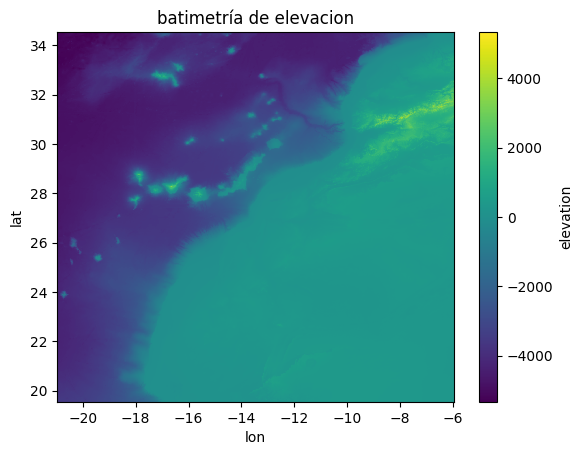

In [4]:
sea_depth_bathymetry['elevation'].plot(cmap='viridis')
plt.title('batimetría de elevacion')
plt.show()

### Generaremos una máscara con las profundidad del océano utilizando los datos de etopo

In [5]:
sea_depth_bathymetry

<xarray.Dataset> Size: 13MB
Dimensions:    (lat: 1797, lon: 1800)
Coordinates:
  * lat        (lat) float64 14kB 19.55 19.56 19.57 19.58 ... 34.51 34.52 34.52
  * lon        (lon) float64 14kB -20.98 -20.97 -20.96 ... -5.992 -5.983 -5.975
Data variables:
    elevation  (lat, lon) float32 13MB -3.524e+03 -3.523e+03 ... 12.93 13.88

### Visualizamos la variable elevación del océano

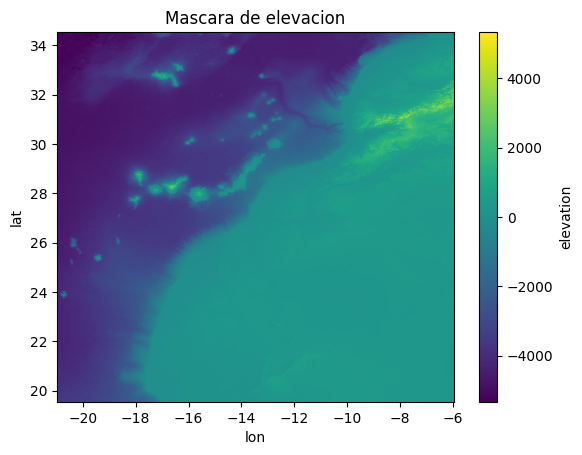

In [6]:
sea_depth_bathymetry['elevation'].plot(cmap='viridis')
plt.title('Mascara de elevacion')
plt.show()

In [7]:
sea_depth_bathymetry.elevation.shape

(1797, 1800)

### Visualizamos las máscaras que se utilizaron para el proyecto original para ver que máscara de estas sería la más parecida y poder así darle un nombre adecuado a la máscara que generaremos.

### máscara de sea_depth

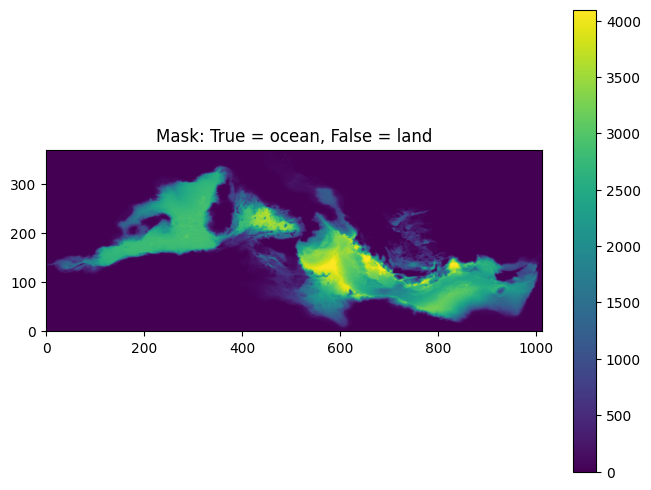

In [8]:
sea_depth_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/sea_depth.npy"
sea_depth = np.load(sea_depth_path)

plt.figure(figsize=(8, 6))
plt.imshow(sea_depth, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

In [9]:
sea_depth.shape

(371, 1013)

### máscara sea topography

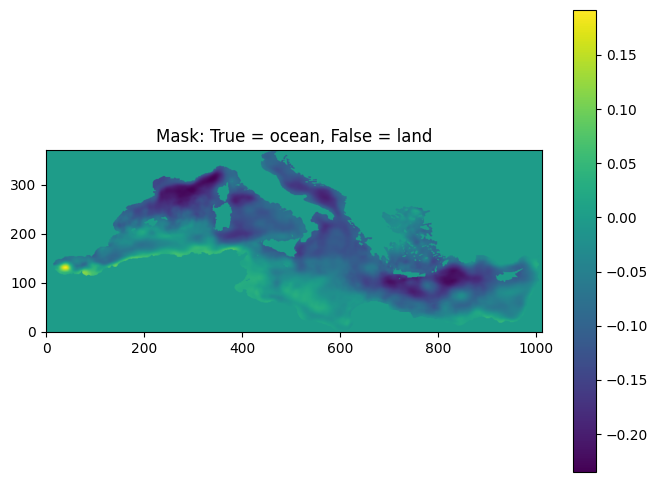

In [10]:
sea_topo_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/sea_topography.npy"
sea_topo = np.load(sea_topo_path)

plt.figure(figsize=(8, 6))
plt.imshow(sea_topo, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

In [11]:
sea_topo.shape

(371, 1013)

### máscara bathy_mask.nc

In [12]:
bathy_original_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/bathy_mask.nc"
bathy_original = xr.open_dataset(bathy_original_path)

bathy_original

<xarray.Dataset> Size: 7MB
Dimensions:    (longitude: 1016, latitude: 380, depth: 18)
Coordinates:
  * longitude  (longitude) float32 4kB -6.0 -5.958 -5.917 ... 36.21 36.25 36.29
  * latitude   (latitude) float32 2kB 30.19 30.23 30.27 ... 45.9 45.94 45.98
  * depth      (depth) float32 72B 1.018 5.465 10.54 16.27 ... 153.4 172.2 192.5
Data variables:
    mask       (depth, latitude, longitude) int8 7MB ...

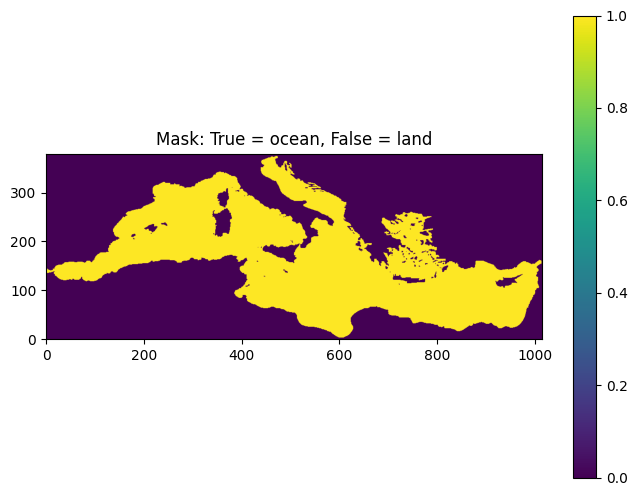

In [13]:
lat = bathy_original.latitude.values
lon = bathy_original.longitude.values

plt.figure(figsize=(8, 6))
plt.imshow(bathy_original.mask.values[0], origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

In [14]:
unicos = np.unique(bathy_original.mask.values[0])
unicos

array([0, 1], dtype=int8)

### máscara sea_mask

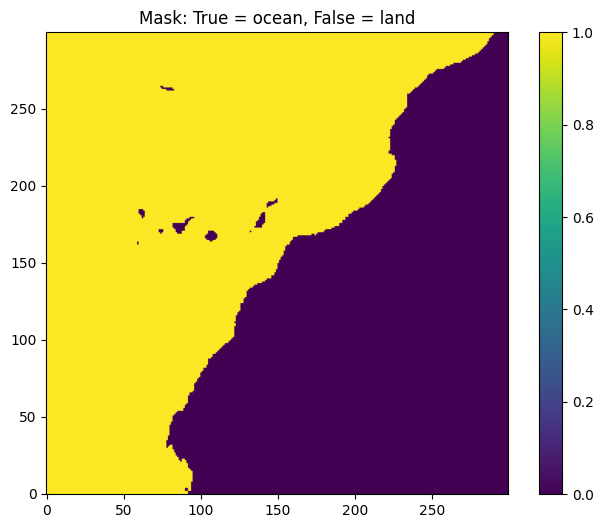

In [2]:
sea_mask_path = "../data/atlantic/static/sea_mask.npy"
sea_mask = np.load(sea_mask_path)
sea_mask = sea_mask[0]
plt.figure(figsize=(8, 6))
plt.imshow(sea_mask, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

In [16]:
np.unique(sea_mask)

array([False,  True])

### Habiendo visto las máscaras anteriores, la máscara que generaremos se llamará sea_depth

In [17]:
def resize_lonxlat(dataset: xr.Dataset, new_lonxlat: tuple) -> xr.Dataset:
    """
    Resize the longitude and latitude dimensions of an xarray dataset.

    Parameters:
    dataset (xr.Dataset): The input xarray dataset.
    new_lonxlat (tuple): A tuple containing the new size of longitude and latitude dimensions, e.g., (lon_size, lat_size).

    Returns:
    xr.Dataset: The resized xarray dataset.

    Raises:
    ValueError: If the dataset does not contain longitude and latitude coordinates.

    Note:
    - The function interpolates the dataset to match the specified new size of the longitude and latitude dimensions.
    - When NaN values are present in the dataset, linear interpolation is used; otherwise, cubic interpolation is used.
    """
    # Find longitude and latitude coordinate names
    lon_name = [key for key in dataset.coords.keys() if re.match(r'^lon', key)][0]
    lat_name = [key for key in dataset.coords.keys() if re.match(r'^lat', key)][0]

    # Get start and end values of longitude and latitude
    lon_start, lon_end = dataset[lon_name].data[0], dataset[lon_name].data[-1]
    lat_start, lat_end = dataset[lat_name].data[0], dataset[lat_name].data[-1]

    # Extract new sizes of longitude and latitude
    lon_size, lat_size = new_lonxlat

    # Check if there are NaN values in the dataset
    there_nan = bool(dataset.isnull().any().to_array().data.any())

    # Interpolate the dataset based on whether NaN values are present
    if not there_nan:
        # Cubic interpolation when no NaN values are present
        return dataset.interp({lon_name: np.linspace(lon_start, lon_end, lon_size),
                               lat_name: np.linspace(lat_start, lat_end, lat_size)},
                               method="cubic")
    else:
        # Linear interpolation when NaN values are present
        return dataset.interp({lon_name: np.linspace(lon_start, lon_end, lon_size),
                               lat_name: np.linspace(lat_start, lat_end, lat_size)},
                               method="linear")

### Hacemos un downsampling de los datos de etopo para que coindida con la resolución de nuetros demás datos e invertimos los valores para que la profuncidad del mar tenga valores positivos y la tierra valores negativos, lo que nos ayudará a futuro a darle mayor peso a la profundidad del mar en el entrenamiento de nuestro modelo.

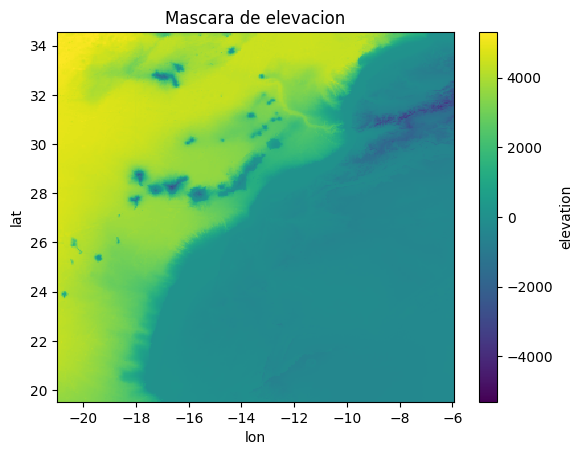

In [18]:
sea_depth_bathymetry_resized = resize_lonxlat(sea_depth_bathymetry, (300, 300))
sea_depth_bathymetry_resized['elevation'] = -sea_depth_bathymetry_resized['elevation']
sea_depth_bathymetry_resized['elevation'].plot(cmap='viridis')
plt.title('Mascara de elevacion')
plt.show()

In [19]:
sea_depth_bathymetry_resized['elevation'].shape

(300, 300)

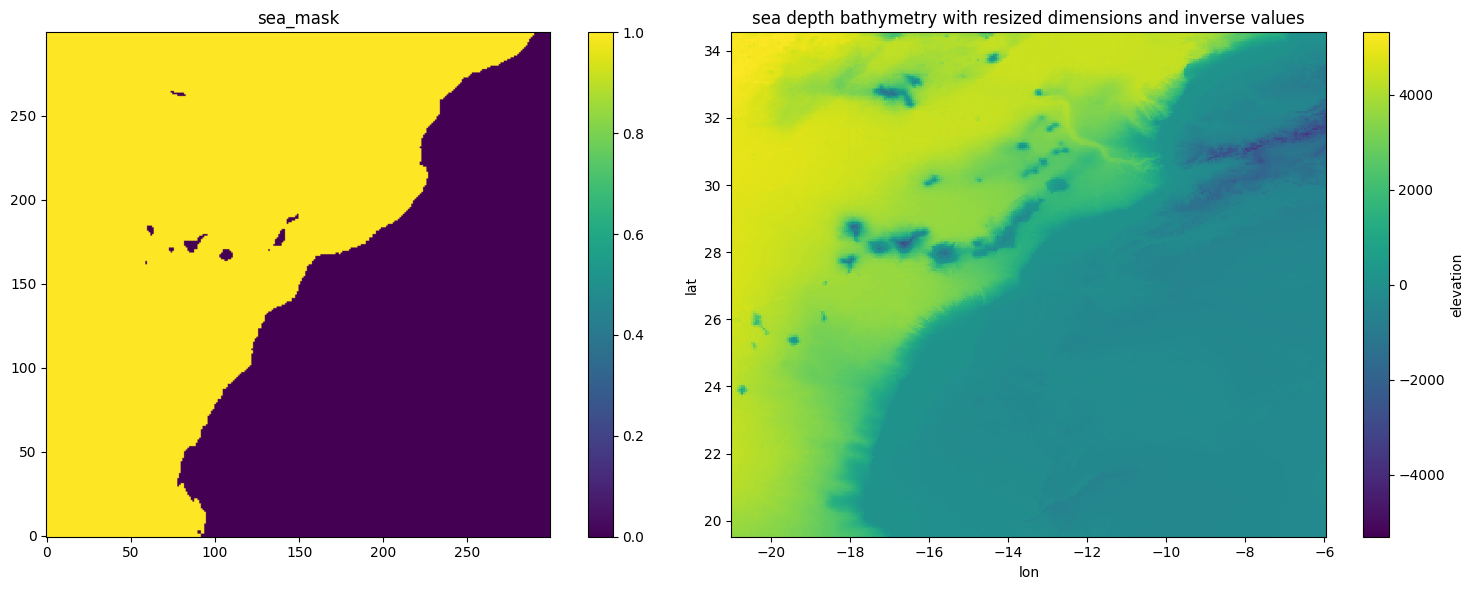

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

im1 = axs[0].imshow(sea_mask, origin='lower', cmap='viridis')
axs[0].set_title("sea_mask")
fig.colorbar(im1, ax=axs[0])

im2 = sea_depth_bathymetry_resized['elevation'].plot(cmap='viridis')
axs[1].set_title("sea depth bathymetry with resized dimensions and inverse values")

plt.tight_layout()
plt.show()

In [21]:
def select_ocean_region(dataset: xr.Dataset, sea_mask: np.ndarray) -> xr.Dataset:
    """
    Selecciona la región oceánica de un dataset de xarray basándose en una máscara marina.

    Parámetros:
        dataset (xr.Dataset): El dataset de entrada.
        sea_mask (np.ndarray): Un array 2D (o con una dimensión extra, por ejemplo, (1, lat, lon)) 
                               que contiene la máscara marina, donde True indica océano y False tierra.

    Retorna:
        xr.Dataset: El dataset de xarray que contiene solo la región oceánica, 
                    con los valores de tierra reemplazados por 0.

    Raises:
        ValueError: Si la máscara no tiene la misma forma que las dimensiones espaciales del dataset.
    """
    # Si la máscara tiene una dimensión extra (por ejemplo, de forma (1, lat, lon)), la reducimos a 2D
    if sea_mask.ndim == 3 and sea_mask.shape[0] == 1:
        sea_mask = np.squeeze(sea_mask, axis=0)
    
    # Verifica que la máscara tenga la misma forma que las dimensiones espaciales del dataset
    if dataset.sizes['lat'] != sea_mask.shape[0] or dataset.sizes['lon'] != sea_mask.shape[1]:
        raise ValueError("La máscara marina no tiene la misma forma que las dimensiones espaciales del dataset.")
    
    # Selecciona la región oceánica: donde la máscara es True se mantienen los datos; donde es False se asigna NaN,
    # y luego se reemplazan los NaN por 0.
    dataset_ocean = dataset.where(sea_mask).fillna(0)
    return dataset_ocean

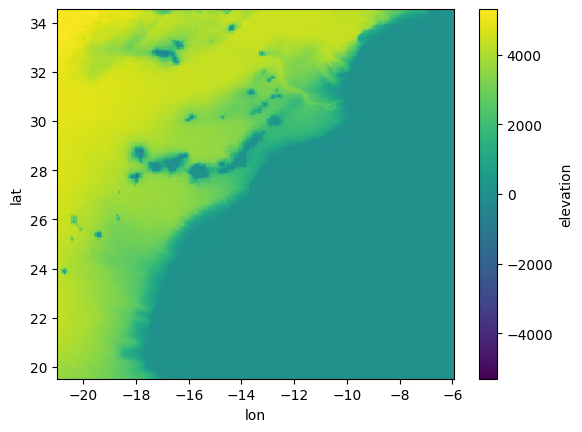

In [22]:
sea_depth_bathymetry_ocean = select_ocean_region(sea_depth_bathymetry_resized, sea_mask)
sea_depth_bathymetry_ocean["elevation"].plot(cmap='viridis')
plt.show()

In [23]:
zeros = np.count_nonzero(sea_depth_bathymetry_ocean['elevation'] == 0)
falses = np.count_nonzero(sea_mask == False)
print(zeros)
print(falses)

40939
40939


In [24]:
total_grid_points = sea_depth_bathymetry_ocean['elevation'].size

water_grid_points = total_grid_points - zeros
print("Etopo sea depth water grid points:", water_grid_points)
print("copernicus sea mask water grid points: ", total_grid_points - falses)

Etopo sea depth water grid points: 49061
copernicus sea mask water grid points:  49061


In [25]:
nans_sea = select_ocean_region(sea_depth_bathymetry_resized, sea_mask)

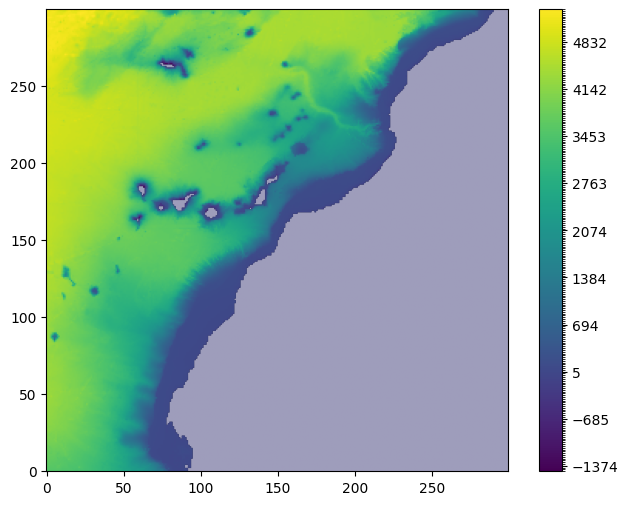

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

# Crea el mapa de colores original (viridis)
cmap = plt.cm.viridis

# Extrae los valores de 'elevation'
elevation = sea_depth_bathymetry_ocean['elevation']
elevation_values = elevation.values

# Define los límites y la normalización para viridis
bounds = np.linspace(np.min(elevation_values), np.max(elevation_values), 256)
norm = BoundaryNorm(bounds, cmap.N, clip=True)

# Crea la figura
plt.figure(figsize=(8, 6))

# Muestra la imagen completa con viridis
img = plt.imshow(elevation, origin='lower', cmap=cmap, norm=norm)

# Crea una máscara para los valores iguales a 0
mask_zero = elevation == 0

mask_nans = nans_sea['elevation'].isnull()
# Sobreimprime los valores 0 con color rojo
# Se usa np.ma.masked_where para que solo se pinten los puntos donde la condición es True
plt.imshow(np.ma.masked_where(~mask_zero, elevation), origin='lower', 
           cmap=plt.cm.Reds, alpha=0.5)

plt.imshow(np.ma.masked_where(~mask_nans, elevation), origin='lower',
           cmap=plt.cm.Greens, alpha=0.8)

# Agrega la barra de color (asociada a la imagen original)
plt.colorbar(img)

# Muestra la gráfica
plt.show()


In [27]:
path = "etopo_bathy.npy"
np.save(path, sea_depth_bathymetry_ocean['elevation'].values)


Simulamos la normalización MinMax de la máscara de profundidad del océano utilizando la fórmula del prepare grid features

Podríamos buscar "suavizar" el impacto de tener valores negativos a causa de las diferencias de resoluciones entre etopo y Copernicus suavizando los valores negativos generados por haber invertido las alturas a causa de mantener constancia con el proyecto original haciendo que estos valores negativos tengan un valor cercano a 0 (0, 0.5 o 1) según sea necesario o incluso imputar valores aleatorios en ese rango a fin de que la normalización sea más precisa en los valores que manejamos.


In [28]:
etopo_bathy = np.load(path)
etopo_bathy[etopo_bathy < 0] = 0

In [29]:
sea_depth = torch.tensor(np.load(path))  # (N_x, N_y)
sea_depth = sea_depth.flatten(0, 1).unsqueeze(1)  # (N_grid_full, 1)
gp_min = torch.min(sea_depth)
gp_max = torch.max(sea_depth)
# Rescale sea_depth to [0,1]
sea_depth_original = (sea_depth - gp_min) / (gp_max - gp_min) 

In [30]:
sea_depth_original

tensor([[0.7360],
        [0.7369],
        [0.7405],
        ...,
        [0.2150],
        [0.2150],
        [0.2150]], dtype=torch.float64)

In [31]:
sea_depth = torch.tensor(etopo_bathy)  # (N_x, N_y)
sea_depth = sea_depth.flatten(0, 1).unsqueeze(1)  # (N_grid_full, 1)
gp_min = torch.min(sea_depth)
gp_max = torch.max(sea_depth)
# Rescale sea_depth to [0,1]
sea_depth_suavizado = (sea_depth - gp_min) / (gp_max - gp_min) 

In [32]:
def normalization_mean_std(tensor: torch.Tensor) -> torch.Tensor:
    """
    Normalize a tensor to have zero mean and unit standard deviation.

    Parameters:
    tensor (torch.Tensor): The input tensor.

    Returns:
    torch.Tensor: The normalized tensor.
    """
    return (tensor - tensor.mean()) / tensor.std()

In [33]:
def simple_normalization_by_mean(tensor: torch.Tensor) -> torch.Tensor:
    """
    Normalize a tensor by dividing it by its mean.

    Parameters:
    tensor (torch.Tensor): The input tensor.

    Returns:
    torch.Tensor: The normalized tensor.
    """
    return tensor / tensor.mean()

In [34]:
sea_depth_normalized2 = normalization_mean_std(sea_depth)
sea_depth_normalized_divided_mean = simple_normalization_by_mean(sea_depth)

In [35]:
torch.set_printoptions(precision=4, sci_mode=False)
print(sea_depth_normalized2)
torch.set_printoptions(profile="default")

tensor([[ 0.9611],
        [ 0.9645],
        [ 0.9772],
        ...,
        [-0.8896],
        [-0.8896],
        [-0.8896]], dtype=torch.float64)


In [36]:
torch.set_printoptions(precision=4, sci_mode=False)
print(sea_depth_normalized_divided_mean)
torch.set_printoptions(profile="default")

tensor([[2.0803],
        [2.0842],
        [2.0984],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], dtype=torch.float64)


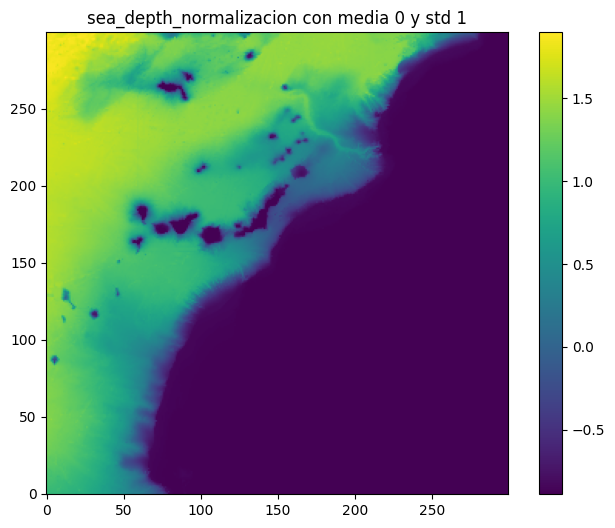

In [37]:
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_normalized2.view(300, 300), origin='lower', cmap='viridis')
plt.title("sea_depth_normalizacion con media 0 y std 1")
plt.colorbar()

In [38]:
#rango de valores
print("Min:", sea_depth_normalized2.min())
print("Max:", sea_depth_normalized2.max())


Min: tensor(-0.8896, dtype=torch.float64)
Max: tensor(1.8990, dtype=torch.float64)


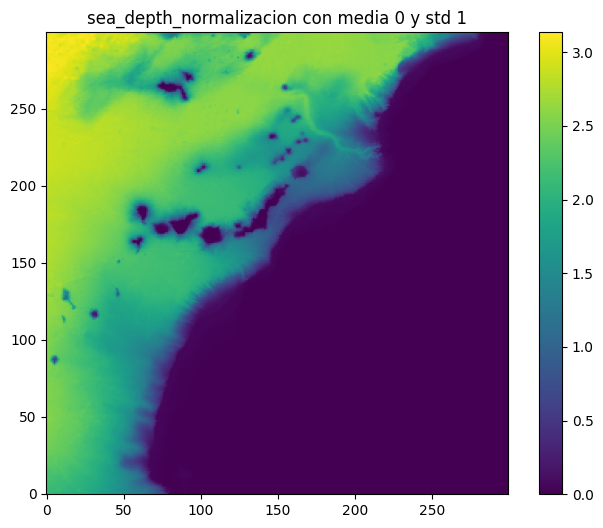

In [39]:
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_normalized_divided_mean.view(300, 300), origin='lower', cmap='viridis')
plt.title("sea_depth_normalizacion con media 0 y std 1")
plt.colorbar()

In [40]:
#rango de valores
print("Min:", sea_depth_normalized_divided_mean.min())
print("Max:", sea_depth_normalized_divided_mean.max())


Min: tensor(0., dtype=torch.float64)
Max: tensor(3.1347, dtype=torch.float64)


In [41]:
torch.set_printoptions(precision=4, sci_mode=False)
print(sea_depth_suavizado)
torch.set_printoptions(profile="default")

tensor([[0.6637],
        [0.6649],
        [0.6694],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], dtype=torch.float64)


In [42]:
sea_depth_original = sea_depth_original.flatten(0, 1)
sea_depth_suavizado = sea_depth_suavizado.flatten(0, 1)
diff = sea_depth_original - sea_depth_suavizado


In [43]:
print("Diferencia entre sea_depth_original y sea_depth_suavizado:")
print(diff)
diff = diff.flatten().tolist()
print("suma total de diferencias: ", np.sum(diff))

Diferencia entre sea_depth_original y sea_depth_suavizado:
tensor([0.0723, 0.0720, 0.0711,  ..., 0.2150, 0.2150, 0.2150],
       dtype=torch.float64)
suma total de diferencias:  13167.964738806653


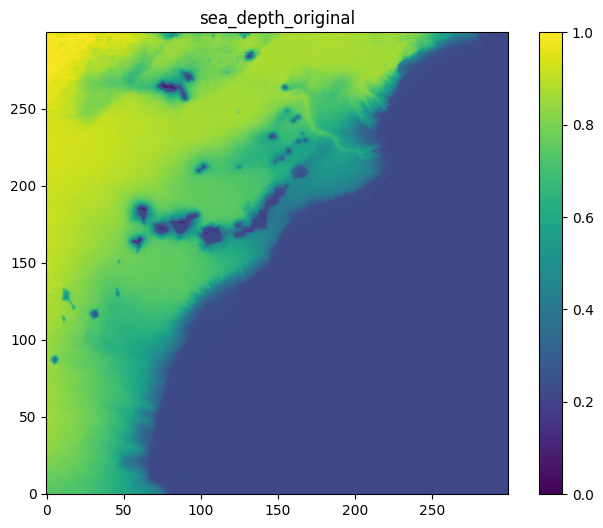

In [44]:
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_original.view(300, 300), origin='lower', cmap='viridis')
plt.title("sea_depth_original")
plt.colorbar()

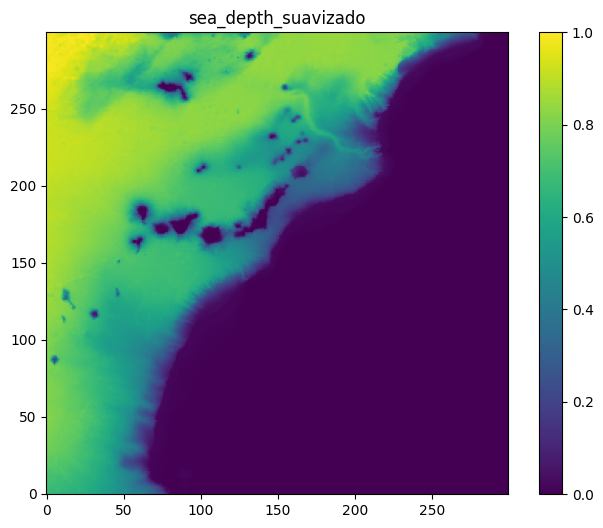

In [45]:
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_suavizado.view(300, 300), origin='lower', cmap='viridis')
plt.title("sea_depth_suavizado")
plt.colorbar()


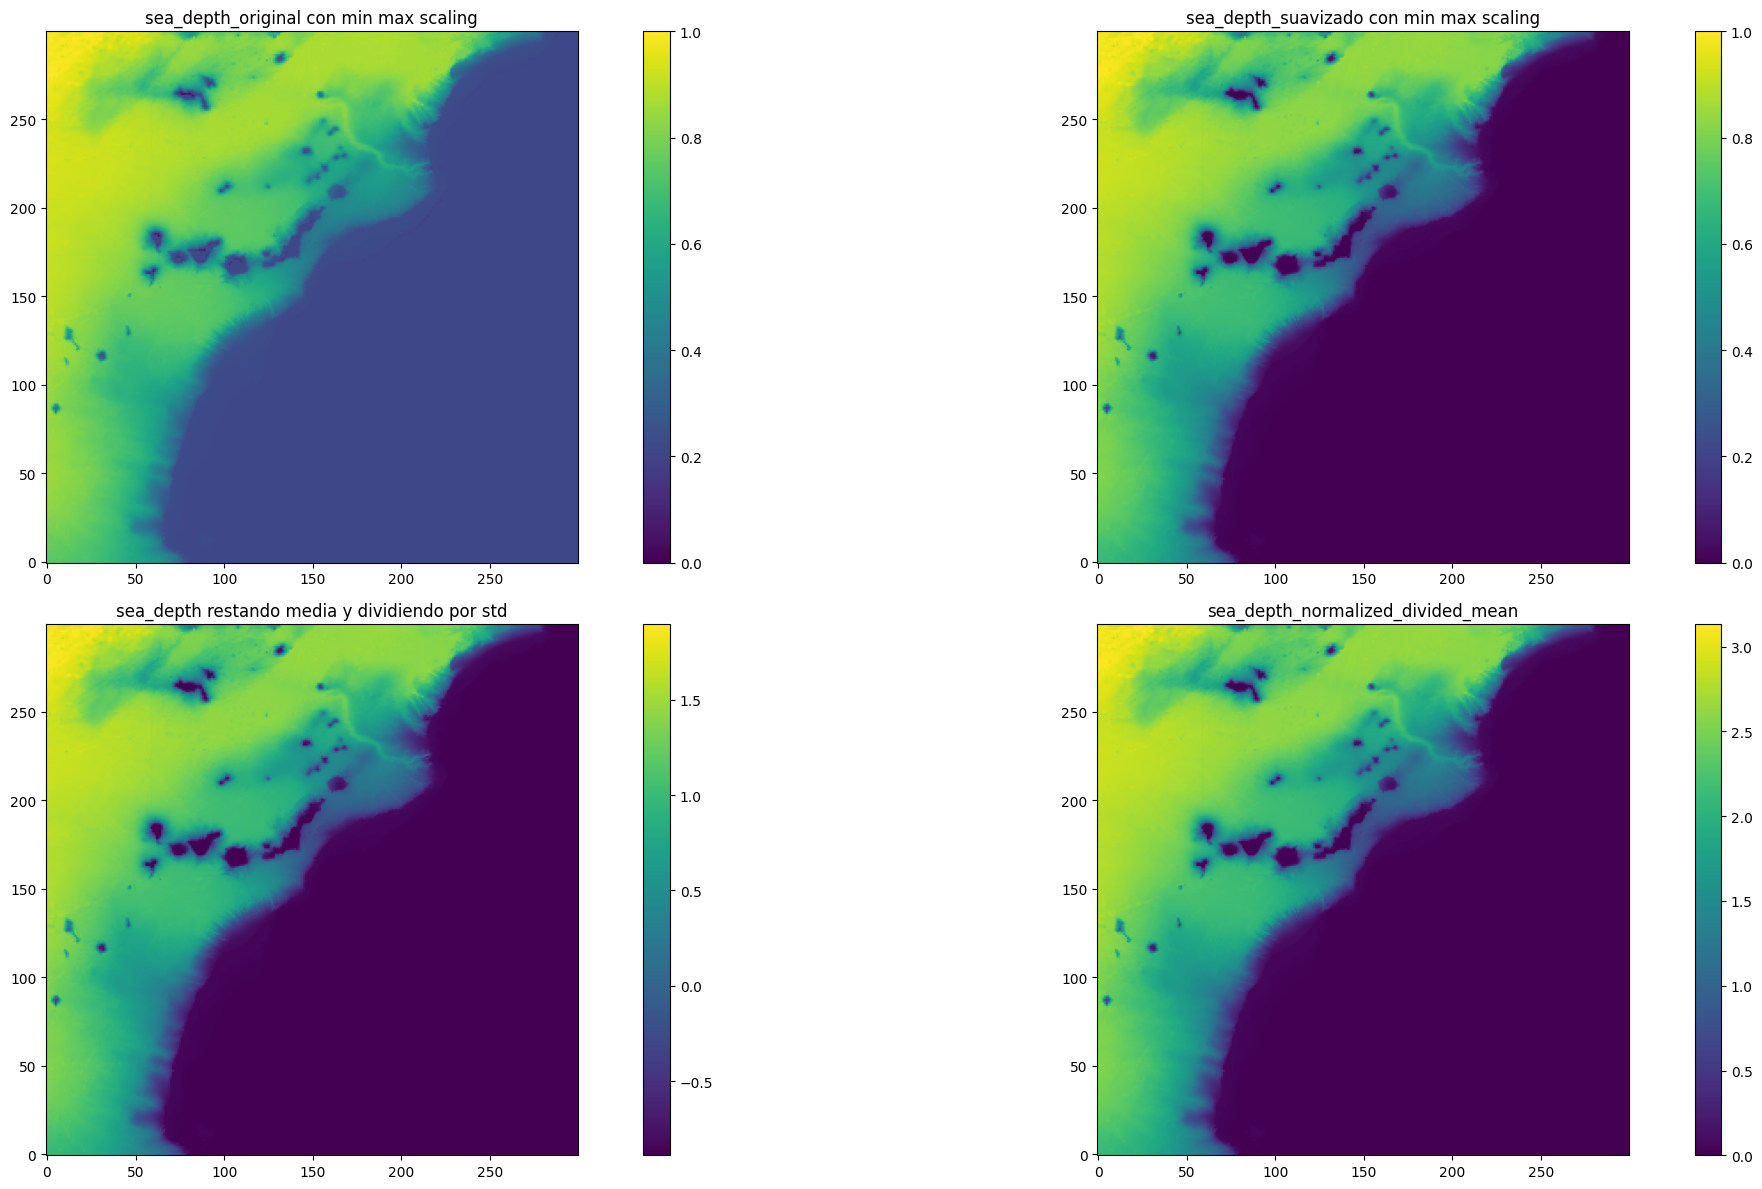

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(24, 12))

im1 = axs[0, 0].imshow(sea_depth_original.view(300, 300), origin='lower', cmap='viridis')
axs[0, 0].set_title("sea_depth_original con min max scaling")
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(sea_depth_suavizado.view(300, 300), origin='lower', cmap='viridis')
axs[0, 1].set_title("sea_depth_suavizado con min max scaling")
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(sea_depth_normalized2.view(300, 300), origin='lower', cmap='viridis')
axs[1, 0].set_title("sea_depth restando media y dividiendo por std")
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(sea_depth_normalized_divided_mean.view(300, 300), origin='lower', cmap='viridis')
axs[1, 1].set_title("sea_depth_normalized_divided_mean")
fig.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()


### Creamos el procedimiento entero para generar la máscara sea_depth

In [47]:
def generate_sea_depth_bathymetry_from_etopo_rescaled_and_filtered(url : str, resolution : tuple, sea_mask : np.ndarray) -> xr.Dataset:
    """
    Generate the sea depth bathymetry data from the ETOPO1 dataset, rescaled to the specified resolution and
    filtered by the sea mask.

    Parameters:
    url (str): The URL to download the sea depth bathymetry data from.
    resolution (tuple): A tuple containing the new size of longitude and latitude dimensions, e.g., (lon_size, lat_size).
    sea_mask (np.ndarray): A 2D array that contains the sea mask, where True indicates ocean and False land.

    Returns:
    xr.Dataset: The sea depth bathymetry data stored in a xarray dataset, rescaled and filtered by the sea mask.
    """

    sea_depth_bathymetry = generate_sea_depth_topography_from_etopo(url)
    sea_depth_bathymetry_resized = resize_lonxlat(sea_depth_bathymetry, resolution)
    sea_depth_bathymetry_resized['elevation'] = -sea_depth_bathymetry_resized['elevation']
    sea_depth_bathymetry_ocean = select_ocean_region(sea_depth_bathymetry_resized, sea_mask)
    sea_depth_bathymetry_ocean["elevation"] = sea_depth_bathymetry_ocean["elevation"].where(
        sea_depth_bathymetry_ocean["elevation"] >= 0, 0
    )
    return sea_depth_bathymetry_ocean

In [24]:
ruta = r'https://gis.ngdc.noaa.gov/arcgis/rest/services/DEM_mosaics/DEM_all/ImageServer/exportImage?bbox=-20.97500,19.55000,-5.97500,34.52500&bboxSR=4326&size=1800,1797&imageSR=4326&format=tiff&pixelType=F32&interpolation=+RSP_NearestNeighbor&compression=LZ77&renderingRule={%22rasterFunction%22:%22none%22}&mosaicRule={%22where%22:%22Name=%27ETOPO_2022_v1_30s_bed%27%22}&f=image'
sea_mask_path = "../data/atlantic/static/sea_mask.npy"
sea_mask = np.load(sea_mask_path)
resolution = sea_mask[0].shape

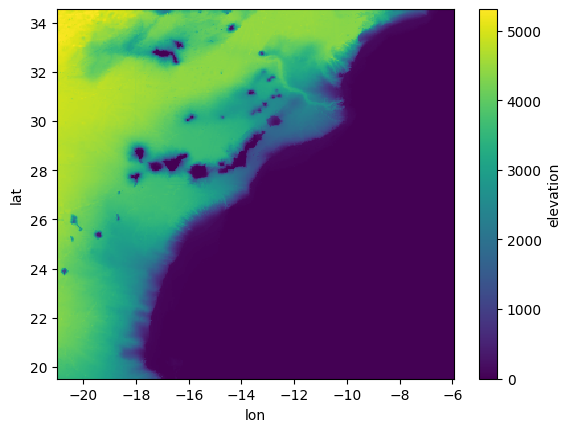

In [49]:
sea_depth_final = generate_sea_depth_bathymetry_from_etopo_rescaled_and_filtered(ruta, resolution, sea_mask)
sea_depth_final["elevation"].plot(cmap='viridis')
plt.show()

### Comprobar guardado

In [50]:
path = "etopo_bathy_final.npy"
np.save(path, sea_depth_final['elevation'].values)


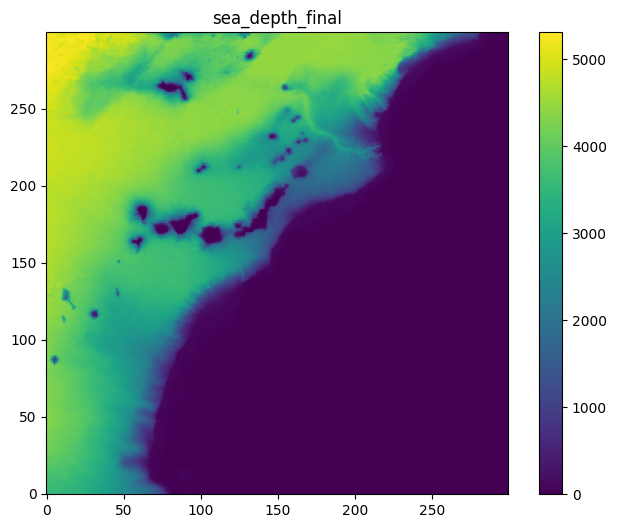

In [51]:
sea_depth_final = np.load(path)
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_final, origin='lower', cmap='viridis')
plt.title("sea_depth_final")
plt.colorbar()
plt.show()


### Comprobar sea_depth generado en download_data.py

In [25]:
sea_mask = sea_mask[0]

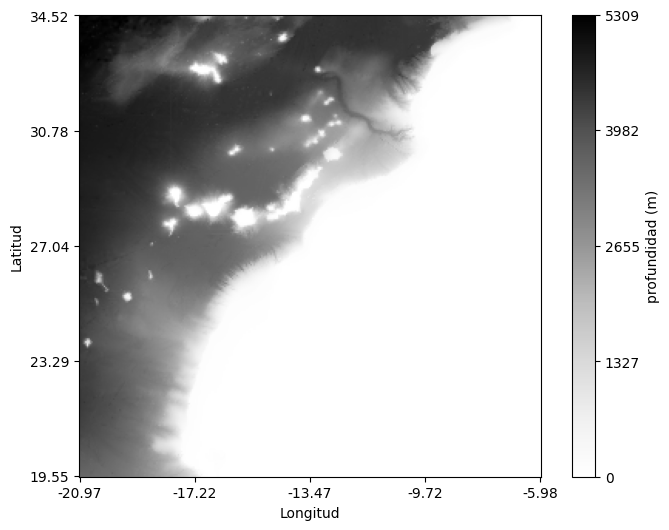

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

path_to_save = "../figures/tfg/masks"
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

path_to_sea_depth_download_data = "../data/atlantic/static/sea_depth.npy"
sea_depth_download_data = np.load(path_to_sea_depth_download_data)

latitude = np.linspace(19.55, 34.525, sea_depth_download_data.shape[0])
longitude = np.linspace(-20.970, -5.975, sea_depth_download_data.shape[1])
long_vals = np.linspace(longitude[0], longitude[-1], 5)
lat_vals = np.linspace(latitude[0], latitude[-1], 5)

plt.figure(figsize=(8, 6))
vmin = np.min(sea_depth_download_data)
vmax = np.max(sea_depth_download_data)
ticks = np.linspace(vmin, vmax, 5)

plt.imshow(sea_depth_download_data, origin='lower', cmap='Greys')  # Escala de grises
plt.colorbar(label='profundidad (m)', ticks=ticks)

plt.xticks(
    ticks=np.linspace(0, sea_depth_download_data.shape[1] - 1, 5),
    labels=np.round(long_vals, 2)
)
plt.yticks(
    ticks=np.linspace(0, sea_depth_download_data.shape[0] - 1, 5),
    labels=np.round(lat_vals, 2)
)

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.gca().set_facecolor('none')

path = os.path.join(path_to_save, "sea_depth_for_tfg.pdf")
plt.savefig(path, format='pdf', dpi=300)
plt.show()


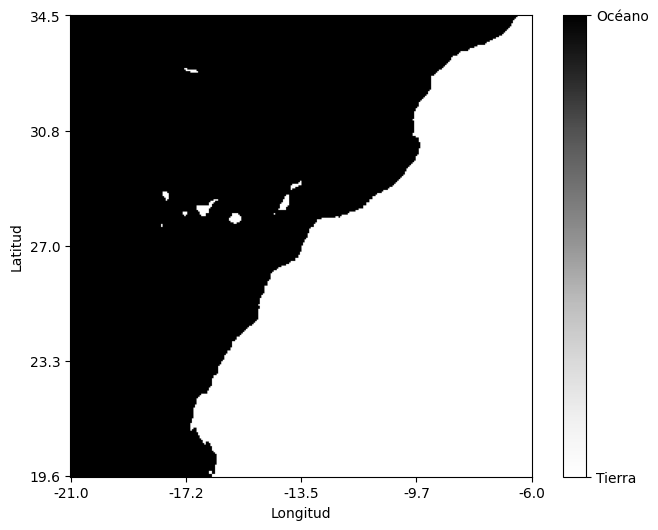

In [55]:
plt.figure(figsize=(8, 6))
plt.imshow(sea_mask, origin='lower', cmap='Greys') #gray for white and black
plt.colorbar(ticks=[0, 1], 
                format=plt.FuncFormatter(lambda x, _: 'Océano' if x == 1 else 'Tierra'))
plt.xticks(ticks=np.linspace(0, sea_mask.shape[1]-1, 5),
           labels=np.round(np.linspace(longitude[0], longitude[-1], 5),
                            1))
plt.yticks(ticks=np.linspace(0, sea_mask.shape[0]-1, 5),
              labels=np.round(np.linspace(latitude[0], latitude[-1], 5), 
                             1))
plt.xlabel('Longitud')
plt.ylabel('Latitud')
path = os.path.join(path_to_save, "sea_mask_for_tfg.pdf")
plt.savefig(path, format='pdf', dpi=300)
plt.show()

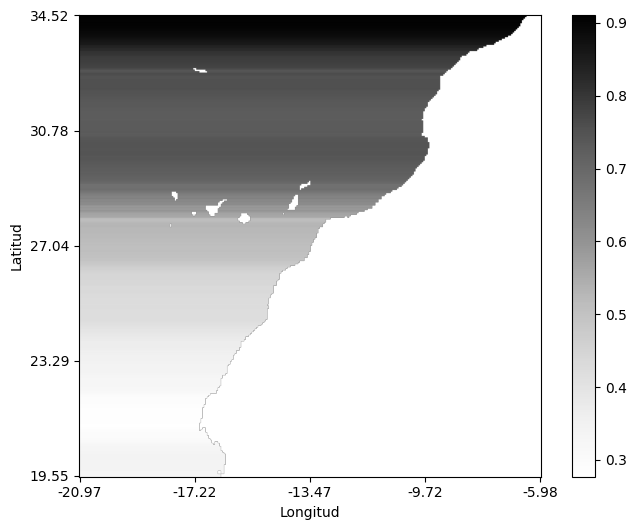

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Rutas
grid_weights_path = "../data/atlantic/static/grid_weights.npy"
sea_mask_path = "../data/atlantic/static/sea_mask.npy"
path_to_save = "../figures/tfg/masks"
os.makedirs(path_to_save, exist_ok=True)

# Cargar datos
grid_weights = np.load(grid_weights_path)
sea_mask = np.load(sea_mask_path)
sea_mask = sea_mask[0]  # Asegurarse de que sea 2D
# Cargar coordenadas
latitude = np.linspace(19.55, 34.525, grid_weights.shape[0])
longitude = np.linspace(-20.970, -5.975, grid_weights.shape[1])

# Aplicar degradado por línea (reconstruyendo las filas constantes)
# Para cada fila (latitud), tomar el valor medio de esa fila (ya calculado por ti) y replicarlo
line_values = np.mean(grid_weights, axis=1)
grid_weights_degraded = np.repeat(line_values[:, np.newaxis], grid_weights.shape[1], axis=1)

# Aplicar máscara para ocultar la tierra
masked_weights = np.where(sea_mask == 1, grid_weights_degraded, np.nan)

# Ticks del colorbar (no se modifican)
vmax = np.max(grid_weights)
vmin = np.min(grid_weights)
vmin2 = np.min(grid_weights[grid_weights > 0])
ticks_values = [vmin, vmin2, (vmin2 + vmax) / 2, vmax]

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(masked_weights, origin='lower', cmap='Greys')
plt.colorbar()

# Ejes
plt.xticks(ticks=np.linspace(0, sea_mask.shape[1] - 1, 5),
           labels=np.round(np.linspace(longitude[0], longitude[-1], 5), 2))
plt.yticks(ticks=np.linspace(0, sea_mask.shape[0] - 1, 5),
           labels=np.round(np.linspace(latitude[0], latitude[-1], 5), 2))
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Guardar
path = os.path.join(path_to_save, "grid_weights_for_tfg.pdf")
plt.savefig(path, format='pdf', dpi=300)
plt.show()


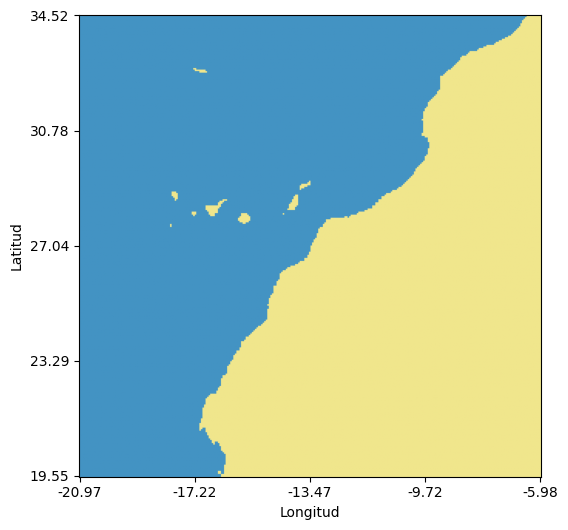

In [63]:
#mapa de la zona a partir de sea_mask
import matplotlib.colors as mcolors
plt.figure(figsize=(8, 6))
colors = ['#f0e68c', '#4393c3']
cmap = mcolors.ListedColormap(colors)
plt.imshow(sea_mask, origin='lower', cmap=cmap)
#round xticks and yticks to 1 decimal places
plt.xticks(ticks=np.linspace(0, sea_mask.shape[1]-1, 5),
           labels=np.round(np.linspace(longitude[0], longitude[-1], 5),
                            2))
plt.yticks(ticks=np.linspace(0, sea_mask.shape[0]-1, 5),
              labels=np.round(np.linspace(latitude[0], latitude[-1], 5), 
                            2))
plt.xlabel('Longitud')
plt.ylabel('Latitud')
path = os.path.join(path_to_save, "map_for_tfg.svg")
plt.savefig(path, format='svg', dpi=300)

In [53]:
path1 = "etopo_bathy.npy"
path2 = "etopo_bathy_final.npy"
os.remove(path1)
os.remove(path2)

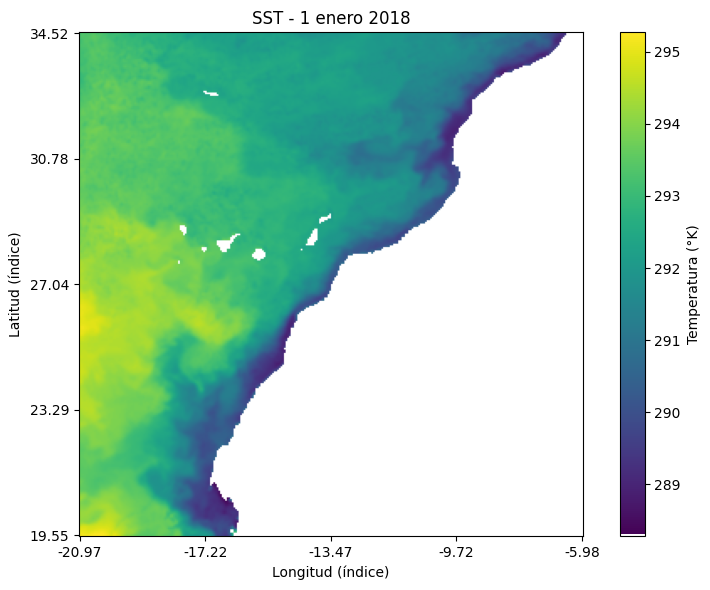

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

# Cargar la SST y la máscara de mar
sst_day_path = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/raw/reanalysis/20180101.npy"
sst_day = np.load(sst_day_path)  # (N, f)
sst_values = sst_day[:, 0]

# Crear matriz 2D de SST
sst_full = np.zeros_like(sea_mask, dtype=np.float32)
sst_full[sea_mask == 1] = sst_values

# Calcular vmin y vmax ignorando los ceros (tierra)
valid_values = sst_full[sea_mask == 1]
vmin = valid_values.min()
vmax = valid_values.max()

# Crear un colormap viridis con color blanco para los ceros
cmap = plt.cm.viridis
new_cmap = cmap(np.linspace(0, 1, 256))
new_cmap[0] = [1, 1, 1, 1]  # Blanco para el índice más bajo (0)
custom_cmap = ListedColormap(new_cmap)

# Visualizar sin que el colorbar tenga en cuenta la tierra
plt.figure(figsize=(8, 6))
im = plt.imshow(sst_full, origin='lower', cmap=custom_cmap, vmin=vmin, vmax=vmax)
plt.title("SST - 1 enero 2018")
plt.colorbar(im, label="Temperatura (°K)")
plt.xlabel("Longitud (índice)")
plt.ylabel("Latitud (índice)")
plt.xticks(ticks=np.linspace(0, sea_mask.shape[1] - 1, 5),
           labels=np.round(np.linspace(longitude[0], longitude[-1], 5), 2))
plt.yticks(ticks=np.linspace(0, sea_mask.shape[0] - 1, 5),
           labels=np.round(np.linspace(latitude[0], latitude[-1], 5), 2))

# Guardar la figura
path = os.path.join(path_to_save, "sst_one_day.pdf")
plt.tight_layout()
plt.savefig(path, format='pdf', dpi=300)
plt.show()
